### 1. Preprocess the data such as highly-variable gene filtering

See https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html for preprocessing

<span style="color:yellow">**Attemp 1:**</span> filter multiple AnnData objects from dataset

From the paper: 

Genes expressed in at least 5 cells, cells having at least 200 genes expressed and cells having less than 8% mitochondrial reads were retained for the analysis.

The thousand most variable genes were selected for each sample and pooled to create a unique list of genes being highly variable in at least two samples (n = 883).

In [20]:
# Environment set-up
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as anndata
import scipy as scipy
import seaborn as sbn
import matplotlib.pyplot as plt

In [12]:
from pathlib import Path

dataset_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE132509')
for adata_path in dataset_directory.iterdir():
    if "_uni.h5ad" in adata_path.name:
        adata = anndata.read_h5ad(adata_path)
        print(adata_path.stem)
        print(adata)
        break

GSM3872444_PBMMC_3_uni
AnnData object with n_obs × n_vars = 2229 × 33694
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode'
    var: 'gene_ids'


In [13]:
# Basic filter
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)
print(adata)

AnnData object with n_obs × n_vars = 2229 × 14405
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'n_genes'
    var: 'gene_ids', 'n_cells'


Filtered out `33694 - 14405 = 19289` genes that are detected in less than 5 cells.

In [14]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
print(adata.var)

                      gene_ids  n_cells     mt  n_cells_by_counts  \
FO538757.2     ENSG00000279457      429  False                429   
AP006222.2     ENSG00000228463       92  False                 92   
RP11-206L10.9  ENSG00000237491       24  False                 24   
LINC00115      ENSG00000225880       31  False                 31   
FAM41C         ENSG00000230368       63  False                 63   
...                        ...      ...    ...                ...   
AC145212.2     ENSG00000274847        6  False                  6   
AL592183.1     ENSG00000273748      116  False                116   
AC007325.4     ENSG00000278817       25  False                 25   
AC004556.1     ENSG00000276345       25  False                 25   
AC240274.1     ENSG00000271254       36  False                 36   

               mean_counts  pct_dropout_by_counts  total_counts  
FO538757.2        0.233288              80.753701         520.0  
AP006222.2        0.043069             

In [15]:
# Remove cells that have too many mitochondrial genes expressed
adata = adata[adata.obs.pct_counts_mt < 8, :]
print(adata)

View of AnnData object with n_obs × n_vars = 2195 × 14405
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [16]:
# Normlization

# First need to store raw counts in the "raw_counts" layer in case for later use
adata.layers['raw_counts'] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=None, inplace=True)

/scratch/temp/8101596/ipykernel_239176/3976240152.py:4: ImplicitModificationWarning: Setting element `.layers['raw_counts']` of view, initializing view as actual.
  adata.layers['raw_counts'] = adata.X.copy()


Text(0.5, 1.0, 'After normalisation')

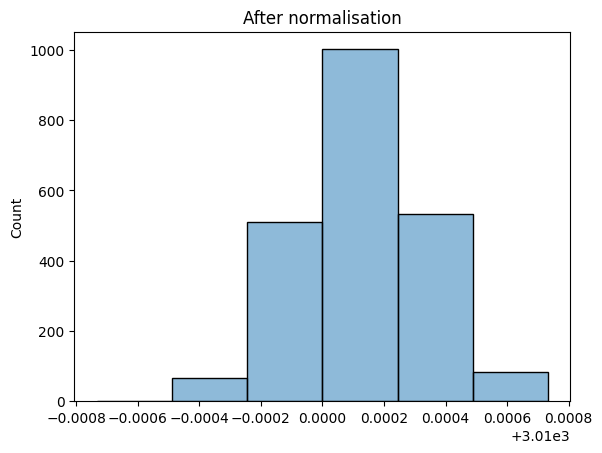

In [26]:
# Visualise after normalisation 
sbn.histplot(adata.X.sum(axis=1), bins=6, discrete=False, legend=False)
plt.title('After normalisation')

Text(0.5, 1.0, 'Before normalisation')

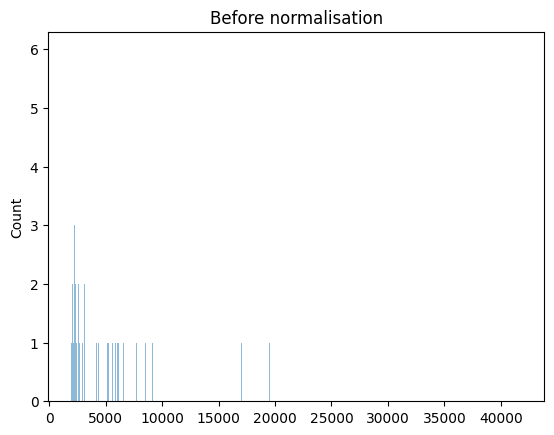

In [22]:
# You can restore the value before normalisation 
sbn.histplot(adata.layers['raw_counts'].sum(axis=1), discrete=True, legend=False)
plt.title('Before normalisation')

AnnData object with n_obs × n_vars = 2195 × 14405
    obs: 'cancer_type', 'dataset', 'tissue', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw_counts'

Filtered out `2229 - 2195 = 34` cells that have more than 8% mitochondrial reads.

### 2. Integration with Scanorama

See https://github.com/brianhie/scanorama for more info